# NDVI Analysis - Arroyo Vivo

This notebook takes in variables (Config notebook) in order to download an process raster images for a certain time period and perform certain analysis.
Output includes the rasters (saved to local), date by date behaviour csv (saved to local), and hexgrid with mean data (saved to local).

Data was saved to local because of an error in the "if_exists:append" parameter of aup.gdf_to_db_slow.

The data can be saved to db using the notebook 01b_ndvi_todb.ipynb

## Import libraries

In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-11-15 18:27:17 Configured OSMnx 1.1.2
2023-11-15 18:27:17 HTTP response caching is on


## Config notebook

In [2]:
# Set raster spectral bands and analysis equation
band_name_dict = {'red':[False], #If GSD(resolution) of band is different, set True.
                  'nir':[False], #If GSD(resolution) of band is different, set True.
                  'eq':["(nir-red)/(nir+red)"]}

# Set analysis name
index_analysis = 'ndvi'

# Set directory to save analysed rasters
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [12]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2016-01-01'
end_date = '2023-11-13'

# Save?
save = True # True

# Del rasters after processing.
del_data = False # True

# input area of interest directory
# gdf_dir = "../../data/external/temporal_todocker/arroyo_vivo/cuenca_arroyo_32614.gpkg"

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'arroyo_vivo'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
query = {"eo:cloud_cover": {"lt": 10}}

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

## Download data

### Download data - area of interest

<AxesSubplot: >

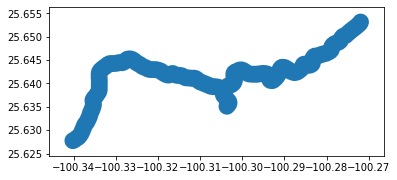

In [3]:
#Load data
gdf_original = aup.gdf_from_db('arroyovivo_buffer200mts','projects_research')
gdf_original.plot()

Area of interest treatment

In [4]:
#Filter for relevant data
columns_tokeep = ['geometry']
gdf = gdf_original[columns_tokeep]

#Create buffer for dam geometry
polygon = gdf.to_crs("EPSG:6372").buffer(250)
polygon = polygon.to_crs("EPSG:4326")
polygon = gpd.GeoDataFrame(geometry=polygon).dissolve().geometry

#Review result
print(polygon.shape)
polygon.head(2)

(1,)


0    POLYGON ((-100.34225 25.63137, -100.34213 25.6...
Name: geometry, dtype: geometry

### Data download - Download and proccess rasters

In [5]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
df_len = aup.download_raster_from_pc(polygon, index_analysis, city, freq, 
                                     start_date, end_date, tmp_dir, band_name_dict, query=query, satellite = satellite)

 32%|███████████████████▎                                         | 30/95 [42:37<2:02:38, 113.20s/it]ERROR 1: TIFFFillTile:Read error at row 5120, col 5120, tile 429; got 0 bytes, expected 396063
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 11, Y offset 19: TIFFReadEncodedTile() failed.
 58%|██████████████████████████████████▏                        | 55/95 [1:28:18<1:17:58, 116.95s/it]ERROR 1: TIFFFillTile:Read error at row 6656, col 6656, tile 454; got 0 bytes, expected 381892
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 14, Y offset 20: TIFFReadEncodedTile() failed.
 98%|███████████████████████████████████████████████████████████▋ | 93/95 [2:58:41<04:34, 137.24s/it]ERROR 1: TIFFFillTile:Read error at row 6144, col 6144, tile 57; got 0 bytes, expected 373708
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 13, Y offset 2: TIFFReadEncodedTile() failed.
100%|██████████████████████████████████

### Debuging / reviewing: download_raster_from_pc step by step

In [7]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a")
gdf = polygon.copy()

In [8]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()
# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest
Fetched 167 items
Created dictionary from items


In [9]:
assets_hrefs

{datetime.date(2016, 1, 16): {'red': ['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/14/R/LP/2016/01/16/S2A_MSIL2A_20160116T171642_N0300_R112_T14RLP_20210527T183616.SAFE/GRANULE/L2A_T14RLP_A002969_20160116T172524/IMG_DATA/R10m/T14RLP_20160116T171642_B04_10m.tif?st=2023-11-15T00%3A04%3A08Z&se=2023-11-16T00%3A49%3A08Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-15T19%3A35%3A57Z&ske=2023-11-22T19%3A35%3A57Z&sks=b&skv=2021-06-08&sig=3m3jElRLso6//YheLb%2B21/LFxL9owor7Y0CJVtOXDLc%3D'],
  'nir': ['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/14/R/LP/2016/01/16/S2A_MSIL2A_20160116T171642_N0300_R112_T14RLP_20210527T183616.SAFE/GRANULE/L2A_T14RLP_A002969_20160116T172524/IMG_DATA/R10m/T14RLP_20160116T171642_B08_10m.tif?st=2023-11-15T00%3A04%3A08Z&se=2023-11-16T00%3A49%3A08Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11

In [10]:
# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
aup.available_data_check(df_len, missing_months) # test for missing months

# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100

# if more than 50% of data is missing, raise error and print message
if pct_missing >= 50:

    raise AvailableData('Missing more than 50 percent of data points')

# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

Created bounding box for raster cropping


In [11]:
# raster creation
print('Starting raster creation for specified time')
# download raster data by month
df_len = aup.create_raster_by_month(df_len, index_analysis, city, tmp_dir,band_name_dict,date_list, gdf_raster_test,gdf_bb, area_of_interest, satellite, query=query)
print('Finished raster creation')

Starting raster creation for specified time


  4%|██▎                                                     | 4/95 [00:19<07:18,  4.82s/it]


AvailableData: Multiple missing months together

### Debuging / reviewing: create_raster_by_month step by step

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

aoi = area_of_interest.copy()
sat = satellite

In [13]:
df_len['able_to_download'] = np.nan
band_name_list = list(band_name_dict.keys())[:-1]

print('\n Starting raster analysis')

# check if file exists, for example in case of code crash
df_file_dir = tmp_dir+index_analysis+f'_{city}_dataframe.csv'
if os.path.exists(df_file_dir) == False: # Or folder, will return true or false
    df_len.to_csv(df_file_dir, index=False)
# create folder to store temporary raster files by iteration
tmp_raster_dir = tmp_dir+'temporary_files/'
if os.path.exists(tmp_raster_dir) == False: # Or folder, will return true or false
    os.mkdir(tmp_raster_dir)


 Starting raster analysis


In [16]:
i = 0

df_raster = pd.read_csv(df_file_dir, index_col=False)

# binary id - checks if month could be processed
checker = 0

# gather month and year from df to save raster
month_ = df_raster.loc[df_raster.index==i].month.values[0]
year_ = df_raster.loc[df_raster.index==i].year.values[0]


print(f'\n Starting new analysis for {month_}/{year_}')

# gather links for raster images
sample_date = datetime(year_, month_, 1)
first_day = sample_date + relativedelta(day=1)
last_day = sample_date + relativedelta(day=31)

# creates time range for a specific month
time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                    f"-{month_:02d}-{last_day.day:02d}"]
# gather links for the date range
items = aup.gather_items(time_of_interest, aoi, query=query, satellite=sat)

# gather links from dates that are within date_list
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
# create dataframe
#df_links = pd.DataFrame.from_dict(assets_hrefs, 
#                                orient='Index').reset_index().rename(columns={'index':'date'})

# dates according to cloud coverage
date_order = [True if (d.month == month_) and (d.year == year_) else False for d in date_list]
date_array = np.array(date_list)
date_filter = np.array(date_order)
dates_ordered = date_array[date_filter]


 Starting new analysis for 1/2016


In [21]:
data_link = 0
time_exc_limit = 900

bands_links = assets_hrefs[dates_ordered[data_link]]
rasters_arrays = aup.func_timeout(time_exc_limit, aup.mosaic_process_v2,args=(bands_links, band_name_dict, gdf_bb, tmp_raster_dir))
out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

# calculate raster index
raster_idx = aup.calculate_raster_index(band_name_dict, rasters_arrays)

RasterioIOError: '/vsicurl/https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/14/R/LP/2016/01/16/S2A_MSIL2A_20160116T171642_N0300_R112_T14RLP_20210527T183616.SAFE/GRANULE/L2A_T14RLP_A002969_20160116T172524/IMG_DATA/R10m/T14RLP_20160116T171642_B04_10m.tif?st=2023-11-15T00%3A04%3A08Z&se=2023-11-16T00%3A49%3A08Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-15T19%3A35%3A57Z&ske=2023-11-22T19%3A35%3A57Z&sks=b&skv=2021-06-08&sig=3m3jElRLso6/YheLb%2B21/LFxL9owor7Y0CJVtOXDLc%3D' not recognized as a supported file format.

In [ ]:
iter_count = 1
    
    while iter_count <= 5:

        # create skip date list used to analyze null values in raster
        skip_date_list = []

        #for data_link in range(len(df_links)):
        for data_link in range(len(dates_ordered)):
            print(f'Mosaic date {dates_ordered[data_link].day}'+
                        f'/{dates_ordered[data_link].month}'+
                        f'/{dates_ordered[data_link].year} - iteration:{iter_count}')

            # check if date contains null values within study area
            #if df_links.iloc[data_link]['date'] in skip_date_list:
            if dates_ordered[data_link] in skip_date_list:
                continue

            try:
                #links_band_1 = df_links.iloc[data_link][list(band_name_dict.keys())[0]]
                #links_band_2 = df_links.iloc[data_link][list(band_name_dict.keys())[1]]
                bands_links = aup.assets_hrefs[dates_ordered[data_link]]

                rasters_arrays = aup.func_timeout(time_exc_limit, mosaic_process_v2,args=(bands_links, band_name_dict, gdf_bb, tmp_raster_dir))
                out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

                # calculate raster index
                raster_idx = aup.calculate_raster_index(band_name_dict, rasters_arrays)
                print(f'Calculated {index_analysis}')
                del rasters_arrays

                print(f'Starting interpolation')

                raster_idx[raster_idx == 0 ] = np.nan # change zero values to nan
                raster_idx = raster_idx.astype('float32') # change data type to float32 to avoid fillnodata error

                print(f'Interpolating {np.isnan(raster_idx).sum()} nan values')
                raster_fill = aup.fillnodata(raster_idx, mask=~np.isnan(raster_idx),max_search_distance=50, smoothing_iterations=0)
                print(f'Finished interpolation to fill na - {np.isnan(raster_fill).sum()} nan')

                with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)

                        dest.close()

                print('Starting null test')

                raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

                gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

                try:
                    # test for nan values within study area
                    aup.raster_nan_test(gdf_raster_test,raster_file)

                    print('Passed null test')

                    # save raster to processing database
                    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)
                        dest.close()
                    print(f'Finished saving {index_analysis} raster')

                    checker = 1
                    iter_count = 6
                    delete_files_from_folder(tmp_raster_dir)
                    break
                except:
                    print('Failed null test')
                    skip_date_list.append(assets_hrefs[list(assets_hrefs.keys())[data_link]])
                    aup.delete_files_from_folder(tmp_raster_dir)

            except:
                print(f'Error in iteration {iter_count}')
                aup.delete_files_from_folder(tmp_raster_dir)
                continue
        iter_count = iter_count + 1

    if checker==0:
        df_raster.loc[df_raster.index==i,'data_id']=0
        df_raster.loc[df_raster.index==i,'able_to_download']=0
        df_raster.to_csv(df_file_dir, index=False)
        print("Falló")
        print(df_raster)
        continue

df_len = pd.read_csv(df_file_dir, index_col=False)

In [ ]:
for i in tqdm(range(len(df_len)), position=0, leave=True):
        
    df_raster = pd.read_csv(df_file_dir, index_col=False)

    # binary id - checks if month could be processed
    checker = 0

    if df_raster.iloc[i].data_id==0:
        continue

    # gather month and year from df to save raster
    month_ = df_raster.loc[df_raster.index==i].month.values[0]
    year_ = df_raster.loc[df_raster.index==i].year.values[0]

    if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
        continue

    print(f'\n Starting new analysis for {month_}/{year_}')

    # gather links for raster images
    sample_date = datetime(year_, month_, 1)
    first_day = sample_date + relativedelta(day=1)
    last_day = sample_date + relativedelta(day=31)

    # creates time range for a specific month
    time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                        f"-{month_:02d}-{last_day.day:02d}"]
    # gather links for the date range
    items = aup.gather_items(time_of_interest, aoi, query=query, satellite=sat)

    # gather links from dates that are within date_list
    assets_hrefs = aup.link_dict(band_name_list, items, date_list)
    # create dataframe
    #df_links = pd.DataFrame.from_dict(assets_hrefs, 
    #                                orient='Index').reset_index().rename(columns={'index':'date'})

    # dates according to cloud coverage
    date_order = [True if (d.month == month_) and (d.year == year_) else False for d in date_list]
    date_array = np.array(date_list)
    date_filter = np.array(date_order)
    dates_ordered = date_array[date_filter]

    # mosaic raster

    iter_count = 1
    
    while iter_count <= 5:

        # create skip date list used to analyze null values in raster
        skip_date_list = []

        #for data_link in range(len(df_links)):
        for data_link in range(len(dates_ordered)):
            print(f'Mosaic date {dates_ordered[data_link].day}'+
                        f'/{dates_ordered[data_link].month}'+
                        f'/{dates_ordered[data_link].year} - iteration:{iter_count}')

            # check if date contains null values within study area
            #if df_links.iloc[data_link]['date'] in skip_date_list:
            if dates_ordered[data_link] in skip_date_list:
                continue

            try:
                #links_band_1 = df_links.iloc[data_link][list(band_name_dict.keys())[0]]
                #links_band_2 = df_links.iloc[data_link][list(band_name_dict.keys())[1]]
                bands_links = aup.assets_hrefs[dates_ordered[data_link]]

                rasters_arrays = aup.func_timeout(time_exc_limit, mosaic_process_v2,args=(bands_links, band_name_dict, gdf_bb, tmp_raster_dir))
                out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

                # calculate raster index
                raster_idx = aup.calculate_raster_index(band_name_dict, rasters_arrays)
                print(f'Calculated {index_analysis}')
                del rasters_arrays

                print(f'Starting interpolation')

                raster_idx[raster_idx == 0 ] = np.nan # change zero values to nan
                raster_idx = raster_idx.astype('float32') # change data type to float32 to avoid fillnodata error

                print(f'Interpolating {np.isnan(raster_idx).sum()} nan values')
                raster_fill = aup.fillnodata(raster_idx, mask=~np.isnan(raster_idx),max_search_distance=50, smoothing_iterations=0)
                print(f'Finished interpolation to fill na - {np.isnan(raster_fill).sum()} nan')

                with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)

                        dest.close()

                print('Starting null test')

                raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

                gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

                try:
                    # test for nan values within study area
                    aup.raster_nan_test(gdf_raster_test,raster_file)

                    print('Passed null test')

                    # save raster to processing database
                    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)
                        dest.close()
                    print(f'Finished saving {index_analysis} raster')

                    checker = 1
                    iter_count = 6
                    delete_files_from_folder(tmp_raster_dir)
                    break
                except:
                    print('Failed null test')
                    skip_date_list.append(assets_hrefs[list(assets_hrefs.keys())[data_link]])
                    aup.delete_files_from_folder(tmp_raster_dir)

            except:
                print(f'Error in iteration {iter_count}')
                aup.delete_files_from_folder(tmp_raster_dir)
                continue
        iter_count = iter_count + 1

    if checker==0:
        df_raster.loc[df_raster.index==i,'data_id']=0
        df_raster.loc[df_raster.index==i,'able_to_download']=0
        df_raster.to_csv(df_file_dir, index=False)
        print("Falló")
        print(df_raster)
        continue

df_len = pd.read_csv(df_file_dir, index_col=False)
print("Se guardó")
print(df_raster)

  0%|        | 0/94 [00:00<?, ?it/s]


 Starting new analysis for 1/2016


  1%| | 1/94 [00:01<01:47,  1.15s/it

Mosaic date 16/1/2016 - iteration:1
Error in iteration 1
Mosaic date 16/1/2016 - iteration:2
Error in iteration 2
Mosaic date 16/1/2016 - iteration:3
Error in iteration 3
Mosaic date 16/1/2016 - iteration:4
Error in iteration 4
Mosaic date 16/1/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        1               NaN
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        1               NaN
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 2/2016


  2%| | 2/94 [00:02<01:43,  1.13s/it

Mosaic date 15/2/2016 - iteration:1
Error in iteration 1
Mosaic date 15/2/2016 - iteration:2
Error in iteration 2
Mosaic date 15/2/2016 - iteration:3
Error in iteration 3
Mosaic date 15/2/2016 - iteration:4
Error in iteration 4
Mosaic date 15/2/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        1               NaN
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 5/2016


  5%| | 5/94 [00:03<01:00,  1.46it/s

Mosaic date 5/5/2016 - iteration:1
Error in iteration 1
Mosaic date 5/5/2016 - iteration:2
Error in iteration 2
Mosaic date 5/5/2016 - iteration:3
Error in iteration 3
Mosaic date 5/5/2016 - iteration:4
Error in iteration 4
Mosaic date 5/5/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 7/2016


  7%| | 7/94 [00:05<00:58,  1.48it/s

Mosaic date 24/7/2016 - iteration:1
Error in iteration 1
Mosaic date 24/7/2016 - iteration:2
Error in iteration 2
Mosaic date 24/7/2016 - iteration:3
Error in iteration 3
Mosaic date 24/7/2016 - iteration:4
Error in iteration 4
Mosaic date 24/7/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 10/2016


 11%| | 10/94 [00:06<00:47,  1.77it/

Mosaic date 12/10/2016 - iteration:1
Error in iteration 1
Mosaic date 12/10/2016 - iteration:2
Error in iteration 2
Mosaic date 12/10/2016 - iteration:3
Error in iteration 3
Mosaic date 12/10/2016 - iteration:4
Error in iteration 4
Mosaic date 12/10/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 11/2016


 12%| | 11/94 [00:09<01:27,  1.06s/i

Mosaic date 1/11/2016 - iteration:1
Error in iteration 1
Mosaic date 1/11/2016 - iteration:2
Error in iteration 2
Mosaic date 1/11/2016 - iteration:3
Error in iteration 3
Mosaic date 1/11/2016 - iteration:4
Error in iteration 4
Mosaic date 1/11/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 12/2016


 13%|▏| 12/94 [00:10<01:28,  1.08s/i

Mosaic date 21/12/2016 - iteration:1
Error in iteration 1
Mosaic date 1/12/2016 - iteration:1
Error in iteration 1
Mosaic date 11/12/2016 - iteration:1
Error in iteration 1
Mosaic date 21/12/2016 - iteration:2
Error in iteration 2
Mosaic date 1/12/2016 - iteration:2
Error in iteration 2
Mosaic date 11/12/2016 - iteration:2
Error in iteration 2
Mosaic date 21/12/2016 - iteration:3
Error in iteration 3
Mosaic date 1/12/2016 - iteration:3
Error in iteration 3
Mosaic date 11/12/2016 - iteration:3
Error in iteration 3
Mosaic date 21/12/2016 - iteration:4
Error in iteration 4
Mosaic date 1/12/2016 - iteration:4
Error in iteration 4
Mosaic date 11/12/2016 - iteration:4
Error in iteration 4
Mosaic date 21/12/2016 - iteration:5
Error in iteration 5
Mosaic date 1/12/2016 - iteration:5
Error in iteration 5
Mosaic date 11/12/2016 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0


 14%|▏| 13/94 [00:11<01:18,  1.03it/

Mosaic date 30/1/2017 - iteration:1
Error in iteration 1
Mosaic date 30/1/2017 - iteration:2
Error in iteration 2
Mosaic date 30/1/2017 - iteration:3
Error in iteration 3
Mosaic date 30/1/2017 - iteration:4
Error in iteration 4
Mosaic date 30/1/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 3/2017


 16%|▏| 15/94 [00:12<01:04,  1.23it/

Mosaic date 1/3/2017 - iteration:1
Error in iteration 1
Mosaic date 21/3/2017 - iteration:1
Error in iteration 1
Mosaic date 1/3/2017 - iteration:2
Error in iteration 2
Mosaic date 21/3/2017 - iteration:2
Error in iteration 2
Mosaic date 1/3/2017 - iteration:3
Error in iteration 3
Mosaic date 21/3/2017 - iteration:3
Error in iteration 3
Mosaic date 1/3/2017 - iteration:4
Error in iteration 4
Mosaic date 21/3/2017 - iteration:4
Error in iteration 4
Mosaic date 1/3/2017 - iteration:5
Error in iteration 5
Mosaic date 21/3/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN

 17%|▏| 16/94 [00:13<01:03,  1.23it/

Mosaic date 30/4/2017 - iteration:1
Error in iteration 1
Mosaic date 30/4/2017 - iteration:2
Error in iteration 2
Mosaic date 30/4/2017 - iteration:3
Error in iteration 3
Mosaic date 30/4/2017 - iteration:4
Error in iteration 4
Mosaic date 30/4/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 6/2017


 19%|▏| 18/94 [00:14<00:48,  1.56it/

Mosaic date 29/6/2017 - iteration:1
Error in iteration 1
Mosaic date 29/6/2017 - iteration:2
Error in iteration 2
Mosaic date 29/6/2017 - iteration:3
Error in iteration 3
Mosaic date 29/6/2017 - iteration:4
Error in iteration 4
Mosaic date 29/6/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 9/2017


 22%|▏| 21/94 [00:15<00:40,  1.80it/

Mosaic date 12/9/2017 - iteration:1
Error in iteration 1
Mosaic date 12/9/2017 - iteration:2
Error in iteration 2
Mosaic date 12/9/2017 - iteration:3
Error in iteration 3
Mosaic date 12/9/2017 - iteration:4
Error in iteration 4
Mosaic date 12/9/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1               NaN
92  2023      9        1               NaN
93  2023     10        0               NaN

[94 rows x 4 columns]

 Starting new analysis for 10/2017


 23%|▏| 22/94 [00:16<00:49,  1.46it/

Mosaic date 27/10/2017 - iteration:1
Error in iteration 1
Mosaic date 7/10/2017 - iteration:1
Error in iteration 1
Mosaic date 27/10/2017 - iteration:2
Error in iteration 2
Mosaic date 7/10/2017 - iteration:2
Error in iteration 2
Mosaic date 27/10/2017 - iteration:3
Error in iteration 3
Mosaic date 7/10/2017 - iteration:3
Error in iteration 3
Mosaic date 27/10/2017 - iteration:4
Error in iteration 4
Mosaic date 7/10/2017 - iteration:4
Error in iteration 4
Mosaic date 27/10/2017 - iteration:5
Error in iteration 5
Mosaic date 7/10/2017 - iteration:5
Error in iteration 5
Falló
    year  month  data_id  able_to_download
0   2016      1        0               0.0
1   2016      2        0               0.0
2   2016      3        0               NaN
3   2016      4        0               NaN
4   2016      5        0               0.0
..   ...    ...      ...               ...
89  2023      6        1               NaN
90  2023      7        1               NaN
91  2023      8        1        

In [32]:
df_len = pd.read_csv(df_file_dir, index_col=False)

In [33]:
df_len

,year,month,data_id,able_to_download
0,2016,1,1,NaN
1,2016,2,1,NaN
2,2016,3,0,NaN
3,2016,4,0,NaN
4,2016,5,1,NaN
...,...,...,...,...
89,2023,6,1,NaN
90,2023,7,1,NaN
91,2023,8,1,NaN
92,2023,9,1,NaN


### Data download - Create hexgrid from area of interest

In [6]:
hex_gdf = gpd.GeoDataFrame(polygon)
hex_gdf['res'] = res[0]

if len(res)>1:
#If there is more than one resolution
    for r in range(res[0]+1,res[-1]+1): #Skips res 8 because, originally, res 8 is already in original hex_gdf
        hex_tmp = aup.create_hexgrid(polygon, r)
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        hex_gdf = pd.concat([hex_gdf, hex_tmp],ignore_index = True, axis = 0)
        del hex_tmp

#If there is only one resolution
else:
    hex_gdf = aup.create_hexgrid(hex_gdf, res[0])
    hex_gdf.rename(columns={f'hex_id_{res[0]}':'hex_id'}, inplace=True)
    hex_gdf['res'] = res[0]
    
#Show
print(hex_gdf.shape)
hex_gdf.head(2)

(25757, 3)


,hex_id,geometry,res
0,8c48a200dda6dff,"POLYGON ((-100.27415 25.65394, -100.27405 25.6...",12
1,8c48a202ba155ff,"POLYGON ((-100.29453 25.64058, -100.29443 25.6...",12


## Data processing to hex and saving

### Data processing - Raster to hex

In [7]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)

    if save:
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

In [8]:
for r in list(hex_gdf.res.unique()):

    processing_chunk = 150000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)
    
    if len(hex_gdf_res)>processing_chunk:
        c_processing = len(hex_gdf_res)/processing_chunk
        
        for i in range(int(c_processing)):
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)
    else:
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

 12%|█████████                                                               | 1/8 [00:53<06:14, 53.45s/it]

 38%|███████████████████████████                                             | 3/8 [02:42<04:31, 54.25s/it]

 62%|█████████████████████████████████████████████                           | 5/8 [04:31<02:43, 54.45s/it]

 88%|███████████████████████████████████████████████████████████████         | 7/8 [06:23<00:55, 55.34s/it]

  0%|                                                                               | 0/11 [00:53<?, ?it/s]
